In [365]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, zscore, gzscore
from talib import RSI, BBANDS, MACD, ATR

from typing import Tuple, List, Dict, Any

In [416]:
START = '2013-01-01'
END = '2013-02-28'
TD_PER_MONTH = 21 # trading days per month, on average
TD_PER_YEAR = 12 * TD_PER_MONTH # trading days per year
# MIN_TD = 2 * TD_PER_YEAR
MIN_TD = 20

DATA_STORE = '../data/assets.h5'

idx = pd.IndexSlice

sns.set_style('whitegrid')


In [ ]:
# load data from data store
def load_raw() -> Tuple[pd.DataFrame, pd.DataFrame]:
    with pd.HDFStore(DATA_STORE) as store:
        prices_raw = store['quandl/wiki/prices']
        stocks_raw = store['us_equities/stocks']
    return prices_raw, stocks_raw

In [80]:
prices_raw, stocks_raw = load_raw()

In [406]:
def preprocess(prices_raw: pd.DataFrame, stocks_raw: pd.DataFrame,
               min_td: int = MIN_TD, start: str = START, end: str = END) -> pd.DataFrame:
    """prepare loaded raw prices into training samples"""
    # handle prices
    prices = prices_raw.loc[
        idx[start: end, :],
        ['adj_open', 'adj_close', 'adj_high', 'adj_low', 'adj_volume']
    ].swaplevel().sort_index().rename(columns=lambda x: x.replace('adj_', ''))
    td_counts = prices.groupby(level="ticker").size()
    qualified_tickers = td_counts[td_counts > min_td].index
    prices = prices.loc[idx[qualified_tickers, :]]

    # handle stocks
    stocks = stocks_raw.loc[:, ['marketcap', 'ipoyear', 'sector']]
    stocks = stocks.loc[~stocks.index.duplicated() & stocks.sector.notnull()]
    stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
    stocks.index.name = 'ticker'

    # we only consider tickers in both stocks and prices
    prices_tickers = prices.index.get_level_values('ticker').unique()
    stocks_tickers = stocks.index.unique()
    shared_tickers = stocks_tickers.intersection(prices_tickers)
    prices = prices.loc[idx[shared_tickers, :]]
    stocks = stocks.loc[shared_tickers]

    # add trade volume columns
    prices['dollar_vol'] = prices['close'] * prices['volume']
    prices['dollar_vol_r21'] = prices['dollar_vol'].groupby(level='ticker').rolling(window=21).mean().reset_index(level=0, drop=True)
    prices['dollar_vol_r21_rank'] = prices.dollar_vol_r21.groupby(level='date').rank(ascending=False)

    # add features from ta-lib
    prices['rsi'] = prices.groupby(level='ticker', group_keys=False).close.apply(RSI)#.reset_index(level=0, drop=True)
    def _calc_bb(group):
        high, mid, low = BBANDS(group)
        return pd.DataFrame({'bb_high': high, 'bb_low': low})
    prices = prices.join(prices.groupby(level='ticker', group_keys=False).close.apply(_calc_bb))#.reset_index(level=0, drop=True))
    prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
    prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
    def _calc_atr(group):
        df = ATR(group.high, group.low, group.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    prices['atr'] = prices.groupby(level='ticker', group_keys=False).apply(_calc_atr)
    def _calc_macd(group):
        macd = MACD(group)[0]
        return macd.sub(macd.mean()).div(macd.std())
    prices['macd'] = prices.groupby(level='ticker', group_keys=False).close.apply(_calc_macd)
    return prices, stocks

In [407]:
prices, stocks = preprocess(prices_raw, stocks_raw)

In [410]:
prices.loc['AAPL']

,open,close,high,low,volume,dollar_vol,dollar_vol_r21,dollar_vol_r21_rank,rsi,bb_high,bb_low,atr,macd
date,,,,,,,,,,,,,
2013-01-02,71.816894,71.195748,71.969911,70.236149,140129500.0,9.976625e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,71.046621,70.296565,71.278740,70.154453,88241300.0,6.203060e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,69.631213,68.338996,69.847109,68.187094,148583400.0,1.015404e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,67.690619,67.937002,68.637250,66.808825,121039100.0,8.223034e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,68.625579,68.119845,68.973109,67.593362,114676800.0,7.811766e+09,NaN,NaN,NaN,0.050158,0.022905,NaN,NaN
2013-01-09,67.755456,67.055209,68.080345,66.911269,101901100.0,6.833000e+09,NaN,NaN,NaN,0.047486,0.012436,NaN,NaN
2013-01-10,68.539993,67.886429,68.562038,66.850321,150286500.0,1.020241e+10,NaN,NaN,NaN,0.012337,0.013042,NaN,NaN
2013-01-11,67.560943,67.470170,68.121141,67.304186,87626700.0,5.912188e+09,NaN,NaN,NaN,0.014367,0.008024,NaN,NaN
2013-01-14,65.185288,65.064689,65.810324,64.644541,183551900.0,1.194275e+10,NaN,NaN,NaN,0.059306,0.001919,NaN,NaN


In [405]:
def _calc_macd(group):
    macd = MACD(group)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices.groupby(level='ticker', group_keys=False).close.apply(_calc_macd)

ticker  date      
FLWS    2013-01-02         NaN
        2013-01-03         NaN
        2013-01-04         NaN
        2013-01-07         NaN
        2013-01-08         NaN
                        ...   
ZBH     2013-02-22    0.398073
        2013-02-25   -0.294446
        2013-02-26   -0.755510
        2013-02-27   -0.921860
        2013-02-28   -0.951780
Name: close, Length: 87170, dtype: float64

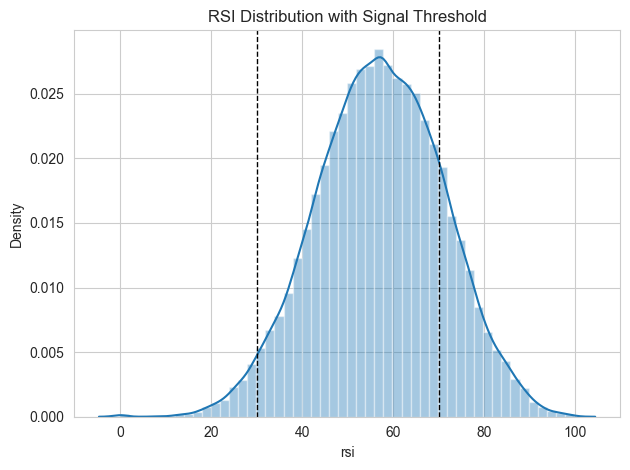

In [417]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

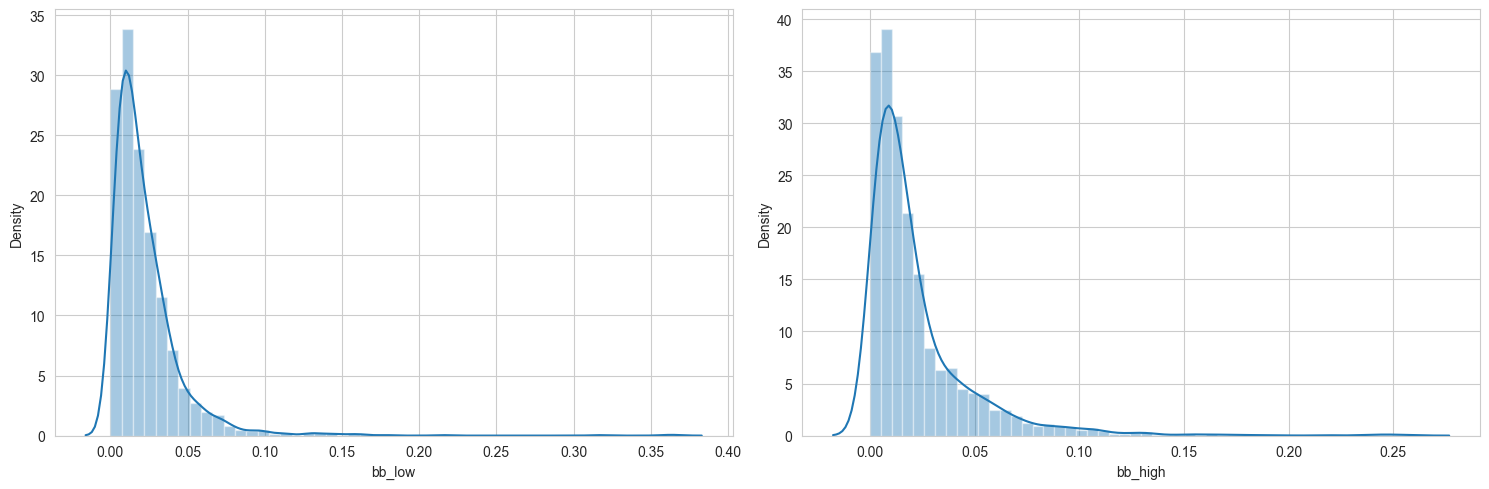

In [419]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_r21_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_r21_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

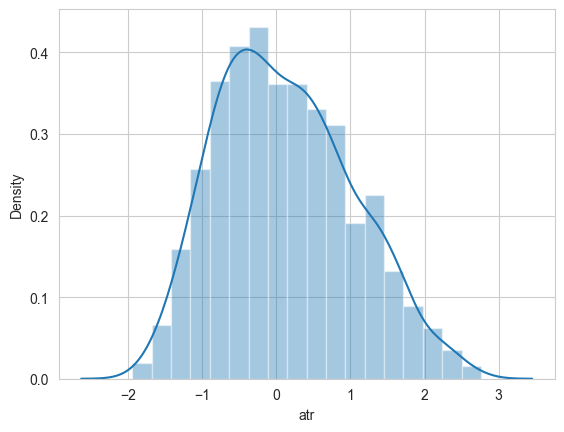

In [420]:
sns.distplot(prices[prices.dollar_vol_r21_rank<50].atr.dropna());

In [423]:
import pandas as pd

# Assume this is your Series of prices
prices = pd.Series([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# Compute returns
returns = prices.pct_change()

# Compute lagged returns
lagged_returns = returns.shift(1)

pd.DataFrame({'prices': prices, 'returns': returns, 'lagged_returns': lagged_returns})

,prices,returns,lagged_returns
0,10,NaN,NaN
1,11,0.100000,NaN
2,12,0.090909,0.100000
3,13,0.083333,0.090909
4,14,0.076923,0.083333
5,15,0.071429,0.076923
6,16,0.066667,0.071429
7,17,0.062500,0.066667
8,18,0.058824,0.062500
9,19,0.055556,0.058824


In [422]:
returns

0          NaN
1     0.100000
2     0.090909
3     0.083333
4     0.076923
5     0.071429
6     0.066667
7     0.062500
8     0.058824
9     0.055556
10    0.052632
dtype: float64